# Gaussian mixture

We use Gaussian mixture models to understand how many formation channels of BH binaries there are, starting from LIGO data about the distribution of the BH masses.

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

Text(0, 0.5, 'Frequency')

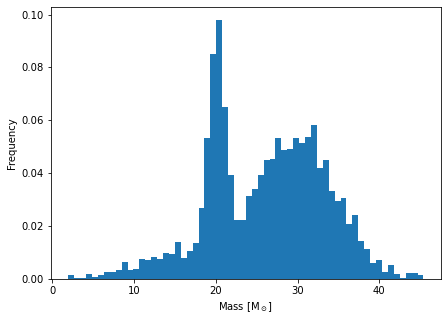

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

data = np.load('formationchannels.npy')

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(data, bins=60, density=True)
ax.set_xlabel('Mass [M$_\odot$]')
ax.set_ylabel('Frequency')

Looking at the distribution plotted above I would intuitively say that there could be 2 or 3 modes.

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Text(0, 0.5, 'Frequency')

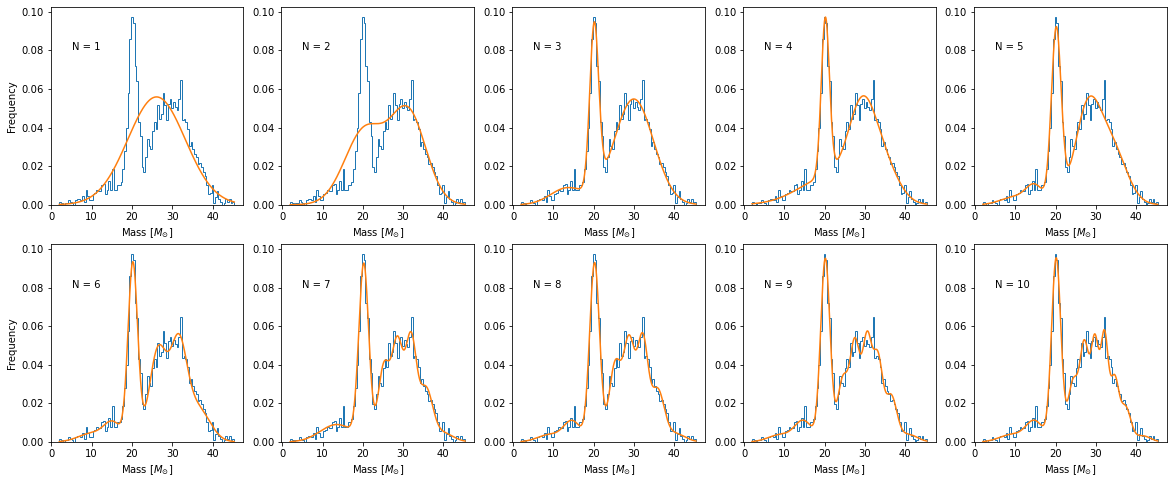

In [2]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
ax = ax.reshape(10)

for i in range(0,10):
    ax[i].hist(data[:,0], bins=100, density=True, histtype = 'step')

x_grid = np.linspace(np.min(data[:,0]), np.max(data[:,0]), 1000)

means = []    #the means of the gaussians are stored here
cov = []      #the covariances are stored here
weights = []  #the weights are stored here
aic = []      #the AIC value is stored here
aic_raw = []  #the AIC value of the function with n_init = 1
fit_g = []    #the best fit model

for j in range(1,11):
    fitfunc = GaussianMixture(n_components=j, n_init=30) #n_init is the number of initialization points from where the L 
                                                         #is maximised
    fitfunc_raw =  GaussianMixture(n_components=j).fit(data) #default n_init=1
    fit_g.append(fitfunc.fit(data))
    means.append(fit_g[j-1].means_)
    cov.append(fit_g[j-1].covariances_)
    weights.append(fit_g[j-1].weights_)
    aic.append(fitfunc.aic(data))
    aic_raw.append(fitfunc_raw.aic(data))
    
    g = []
    for i in range(0,j):
        g.append(norm(loc=means[j-1][i], scale = (cov[j-1][i])**0.5))

    y_func = np.zeros(len(x_grid))
    
    for i in range(0,j):
        y_func += (g[i].pdf(x_grid)*weights[j-1][i])[0]

    ax[j-1].plot(x_grid, y_func)
    ax[j-1].set_xlabel('Mass [$M_{\odot}$]')
    ax[j-1].text(5, 0.08, 'N = %.0f' %j)
    
ax[0].set_ylabel('Frequency')
ax[5].set_ylabel('Frequency')

The plot above shows the different best fit models (found with *n_init*=30) for different N Gaussian components. The ones with 1 and 2 components data are definetely underfitted, while at N>5 data seem to be overfitted. Intuitively I would say that the best fit model should be the one with 3 or 4 components.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

The best fit model has  3.0  components


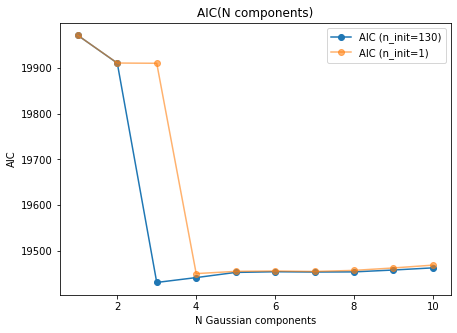

In [3]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
j = np.linspace(1,10,10)

ax.plot(j, aic, marker='o', label='AIC (n_init=130)')
ax.plot(j, aic_raw, marker = 'o', alpha=0.6, label='AIC (n_init=1)')
sort_ind = np.argsort(aic)
j_min = j[sort_ind[0]]
print('The best fit model has ', j_min, ' components')
ax.set_title('AIC(N components)')
ax.set_xlabel('N Gaussian components')
ax.set_ylabel('AIC')
ax.legend()

The variable *n_init* represents the number of starting points from where to search for the Likelihood maximum. The default is *n_init* = 1 and in this way the preferred model is the Gaussian mixture with 4 components, but increasing *n_init*, so having a better idea of the Likelihood function, we can clearly see how the 3-components model is preferred. The variable *n_init* therefore is really important in the understanding of the result.

The best fit model is the 3 component Gaussian mixture!

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

Text(0.5, 1.0, 'best-fit model')

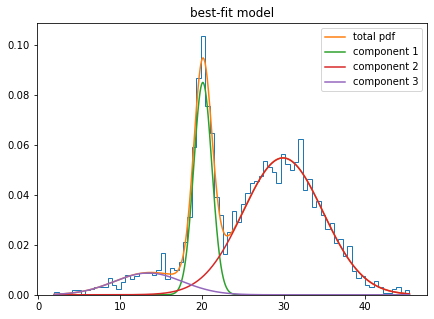

In [4]:
best_mod = fit_g[sort_ind[0]] #best fitting model is the one with the lowest aic

lnL = best_mod.score_samples(x_grid.reshape(-1,1)) #score_samples computes the lnL of a model
L = np.exp(lnL) #and the Likelihood(x) corresponds to the probability of extracting x given that model (so to the pdf(x))


comp_prob = best_mod.predict_proba(x_grid.reshape(-1,1)) #predict_proba gives you the components' density for each sample 
                                                         #so the probability that a measurement belongs to each Gaussian component
                                                         #of the model
ind_comp  = L[:,np.newaxis]*comp_prob #each Gaussian in the model

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.hist(data[:,0], bins=80, density=True, histtype = 'step')
ax.plot(x_grid, L, label='total pdf')

for i in range(len(ind_comp[0])):
    ax.plot(x_grid, ind_comp[:,i], label='component %.0f' %(i+1))

ax.legend()

ax.set_title('best-fit model')

### A little bit of theory

The Likelihood of a datum $x_{i}$ in a Gaussian mixture model with M gaussians is given by:
$$p(x_i|\theta) = \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \sigma_j)$$
Where $\mu_j$ and $\sigma_j$ are the mean and the std of the j-th Gaussian component and $\alpha_j$ is the normalization factor. In order for it to be a pdf we need that $\sum_{j=1}^{M} \alpha_j = 1$. Therefore the log-likelihood of a data set of length N is:
$$\ln{L} = \sum_{i=1}^{N}\ln\big[\sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \sigma_j)\big]$$
and it has $k = 3M-1$ parameters to maximise (the -1 arises from the normalization condition on the $\alpha_j$).

Since for each datum we cannot know the Gaussian component from which it is generated, what we can compute is the so called *responsability* factor, that is, given a model with M gaussian components, the probability for each data value that it is generated from the j-th gaussian. This is obtained from Bayes' theorem:

$$p(j|x_i)p(x_i) = p(x_i|j)p(j)$$

Where $p(x_i)$ is the probability of extracting $x_i$ given the j-components model:

$$p(x_i) = \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \sigma_j)$$ 

$p(j)$ is the probability associated to the j-th component of the model:

$$p(j) = \alpha_j $$

And $p(x_i|j)$ is the probability of extracting $x_i$ given the j-th gaussian, which is:

$$p(x_i|j) = \mathcal{N}(\mu_j, \sigma_j)$$
Therefore:

$$p(j|x_i) = \frac{\alpha_j \mathcal{N}(\mu_j, \sigma_j)}{\sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \sigma_j)}$$

And we have that:

$$\sum_{j}{p(j|x_i)} = 1$$

And if $x_i$ is not within a few $\sigma_j$ from $\mu_j$ the probability $p(j|x_i)$ will be low.